# LSC Notebook

## LSC studies

In [1]:
import time

In [2]:
from __future__ import print_function

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import mplFunctions as mpl
import wfmFunctions as wfm
import sensorFunctions as snf
from Util import *
import FEParam as FP
from scipy import signal as SGN

In [7]:
%env PYTHONPATH

'/Users/jjgomezcadenas/Documents/Development/NEXT/IC:/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Cities:/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Notebooks:/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Utilities:/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Sierpe:/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Core:/Users/jjgomezcadenas/Documents/Development/NEXT/CyIC:/usr/local//lib:/usr/local/lib://System/Library/Frameworks/Python.framework/Versions/Current/'

In [8]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [9]:
print(time.strftime("%d/%m/%Y"))
print(time.strftime("%H:%M:%S"))

10/10/2016
19:20:49


### Access to LSC

### Script DAQ to h5

In [11]:
from alpha_pmt import *

## October Argon run

In [10]:
def get_vectors(h5f):
    """
    input: file pointer
    returns: data vectors
    """
    pmtrwf = h5f.root.RD.pmtrwf
    sipmrwf = h5f.root.RD.sipmrwf
    geom_t = h5f.root.Detector.DetectorGeometry
    pmt_t = h5f.root.Sensors.DataPMT
    sipm_t = h5f.root.Sensors.DataSiPM
    gdf = snf.read_data_geom(geom_t)
    pmtdf = snf.read_data_sensors(pmt_t)
    sipmdf = snf.read_data_sensors(sipm_t)
    return pmtrwf,sipmrwf,pmtdf,sipmdf,gdf
    

In [34]:
def get_pmt_vectors(h5f):
    """
    input: file pointer
    returns: data vectors
    """
    pmtrwf = h5f.root.RD.pmtrwf
    geom_t = h5f.root.Detector.DetectorGeometry
    pmt_t = h5f.root.Sensors.DataPMT
    gdf = snf.read_data_geom(geom_t)
    pmtdf = snf.read_data_sensors(pmt_t)
    return pmtrwf,pmtdf,gdf

In [11]:
def wfdf(time,energy_pes,indx):
    """
    takes three vectors (time, energy and indx) and returns a data frame representing a waveform
    """
    swf = {}
    swf['time_mus'] = time/mus
    swf['ene_pes'] = energy_pes 
    swf['indx'] = indx
    return pd.DataFrame(swf)

In [12]:
def waveform_panel(pmtrwf,pmtdf,mau_len = 500, calib_constat =True, adc_to_pes=20, 
                   type = 'PMT', daq_ceiling=4096, event=0):
    """
    input: sensor (pmt or sipm) data vector, sensor data frame (position, calibration)
    returns: a panel holding waveforms for all sensors, and a series for the baselines
    """
    PMT = {}
    nm = mau_len
    B_MAU = (1./nm)*np.ones(nm)
    pmt_len = pmtrwf.shape[2]
    NPMT = pmtrwf.shape[1]
    MAU = np.zeros(nm)
    BSL = {}
    
    time_ns = np.arange(pmt_len)*mus
    indx = np.arange(pmt_len)
    
    if type == 'PMT':
        time_ns = np.arange(pmt_len)*FP.time_DAQ
        
    ene_sum = 0
    for j in range(NPMT):
                     
        if calib_constat == True:
            adc_to_pes = abs(pmtdf['adc_to_pes'][j])
            
        signal_daq = pmtrwf[event,j]
        if type == 'PMT':
            signal_daq = daq_ceiling - pmtrwf[event,j]
            
        MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
        BASELINE = MAU[nm-1]
        
        ene_pes = (signal_daq - BASELINE)/adc_to_pes
        if type == 'PMT':
            ene_sum += ene_pes
            
        PMT[j] = wfdf(time_ns,ene_pes,indx)
        BSL[j] = BASELINE
    PMT[j+1] = wfdf(time_ns,ene_sum,indx)
    return pd.Panel(PMT),pd.Series(BSL)


In [13]:
def plot_PPMT(pmt_panel, tmin=0, tmax=1200, emin = 0, emax = 10000, option='sum'):
    """
    Plots pmtwf
    """
    plt.figure(figsize=(10,10))
    
    if option == 'sum':
        ax1 = plt.subplot(1,1,1)
        ax1.set_xlim([tmin, tmax])
        ax1.set_ylim([emin, emax])
        indx = pmt_panel.items[-1]
        pmtwf = pmt_panel[indx]
        plt.plot(pmtwf['time_mus'],pmtwf['ene_pes'])
    else:
        
        for i in pmt_panel.items[0:-1]:
            ax1 = plt.subplot(3,4,int(i)+1)
            ax1.set_xlim([tmin, tmax])
            ax1.set_ylim([emin, emax])
        
            pmtwf = pmt_panel[i]
            plt.plot(pmtwf['time_mus'],pmtwf['ene_pes'])
    
    plt.show()

In [14]:
def wf_thr(wf,threshold=0):
    """
    return a zero supressed waveform (more generally, the vaules of wf above threshold)
    """
    return wf.loc[lambda df: df.ene_pes.values >threshold, :]

In [15]:
def energy_sum(sensor_panel, thr=0):
    """
    Sum the WFs of PMTs and SiPMs (MC) and store the total energy in PES
    """     
    EPES = []

    for i in sensor_panel.items[0:-1]:
        pmtwf = sensor_panel[i]
        EPES.append(np.sum(pmtwf.ene_pes.values[np.where(pmtwf.ene_pes.values>thr)]))
    return pd.Series(EPES) 

In [16]:
def plot_sensors(geom_df,sensor_df, energy, radius=10):
    """
    plots the energy of the sensors 
    """
    x =sensor_df['x'].values
    y =sensor_df['y'].values
    r =np.ones(len(sensor_df['x'].values))*radius
    
    plt.figure(figsize=(10,10))
    ax = plt.subplot(aspect='equal')
    mpl.circles(x, y, r, c=energy, alpha=0.5, ec='none')
    plt.colorbar()
    
    plt.xlim(geom_df['xdet_min'],geom_df['xdet_max'])
    plt.ylim(geom_df['ydet_min'],geom_df['ydet_max'])
    

In [17]:
def find_S12(swf, stride=40):
    """
    Find S1 or S2 signals. The input is a zero-supressed WF. The stride defines the contiguity criterium.
    The stride is applied to the indexes which keep the ordering of the original (non-zs) WF. 
    For example, with a stride of 40 (corresponding to steps of 1 mus for a DAQ timing of 25 ns) index 1
    and index 39 are in the same S12. 
    """
    T = swf['time_mus'].values
    P = swf['ene_pes'].values
    I = swf['indx'].values
    
    S12 = {}
    pulse_on = 1
    j=0
    
    S12[0] = []
    S12[0].append([T[0],P[0],I[0]])
    
    for i in range(1,len(swf)) :
        if swf.index[i]-stride > swf.index[i-1]:  #new s12
            j+=1
            S12[j] = []
            S12[j].append([T[i],P[i],I[i]])
        else:
            S12[j].append([T[i],P[i],I[i]])
            
    S12L=[]
    for i in S12.keys():
        S12L.append(pd.DataFrame(S12[i], columns=['time_mus','ene_pes','indx']))
    return S12L

In [18]:
def rebin_waveform(swf, stride = 40):
    """
    rebins the a waveform according to stride 
    The input waveform is a vector such that the index expresses time bin and the
    contents expresses energy (e.g, in pes)
    The function returns a DataFrame. The time bins and energy are rebinned according to stride
    """
    
    t = swf['time_mus'].values
    e = swf['ene_pes'].values
    I = swf['indx'].values
    n = len(swf)/int(stride)
    r = len(swf)%int(stride)
    
    lenb = n
    if r > 0: 
        lenb = n+1
    
    T = np.zeros(lenb)
    E = np.zeros(lenb)
    II = np.zeros(lenb, dtype=int)
    
    j=0
    for i in range(n):
        E[i] = np.sum(e[j:j+stride])
        T[i] = np.mean(t[j:j+stride])
        II[i] = I[(j+stride)/2]
        j+= stride
        
    if r > 0:
        E[n] = np.sum(e[j:])
        T[n] = np.mean(t[j:])
        II[n] = I[(len(swf) - j/2)]
    
   
    rbw={}
    rbw['ene_pes'] = E
    rbw['time_mus'] = T
    rbw['indx'] = II
    return pd.DataFrame(rbw)

In [95]:
def find_t0(s1):
    """
    returns t0
    """
    emax = np.amax(s1.ene_pes.values)
    return s1.loc[lambda df: df.ene_pes.values ==emax, :]

In [96]:
def s12_energy(s12):
    """
    total energy in pes
    """
    return np.sum(s12.ene_pes.values)

In [97]:
def s12_length(s12):
    """
    s2 length in mus
    """
    
    return s12.describe().time_mus['max'] - s12.describe().time_mus['min']

In [98]:
def s12_peak(s2):
    """
    s2 peak in mus
    """
        
    return s12.describe().time_mus['max'], s2.describe().ene_pes['max']

In [99]:
def find_t(s1,s2):
    """
    returns the time of the interaction
    """
    t0 = find_t0(s1).time_mus.values[0]
    ts2,es2 = s12_peak(s2)
    return ts2 - t0
        

In [24]:
def sipm_s2(sipmdf, s2df):
    """
    Takes a sipm DF and an s2df
    Returns a DF with the sipm values in the range specified by s2
    """
    s2ti = s2df.time_mus.values[0]
    s2tf = s2df.time_mus.values[-1]
    dfl = sipmdf.loc[lambda df: df.time_mus.values >= s2ti, :]
    dfu = dfl.loc[lambda df: df.time_mus.values < s2tf, :]
    return dfu

In [25]:
def sipm_s2_panel(sipmp, s2, thr_min=0.5, thr_s2 =1, event_number=0):
    """
    Takes a sipmp
    Returns a sipm panel with a collection of sipm DF such that:
    1. the range of the sipm is specified by s2
    2. the sipm energy are above threshold.
    """
    
    j=0
    SIPM={}
    ESIPM=[]
    for i in (sipmp.items):
        sipm = sipmp[i]
        ESIPM.append(np.sum(sipm.ene_pes))
        
        if np.sum(sipm.ene_pes) < thr_min:  #only worry about SiPM with energy above threshold
            continue
            
        sipms2 = sipm_s2(sipm, s2)
        if np.sum(sipms2).ene_pes > thr_s2:
            SIPM[j] = sipms2
            j+=1
    return pd.Panel(SIPM), np.array(ESIPM)
 

In [26]:
def sipm_s2_energy(sipmp, s2, thr_min=0.5, thr_s2 =0.5):
    """
    Takes a sipmp
    Returns a sipm panel where every member is a SiPM which has energy above trheshold:
    The energy of the SiPM corresponds to the S2 width

    """
    
    j=0
    SIPM={}
    for i in (sipmp.items):
        sipm = sipmp[i]
        etot = np.sum(sipm.ene_pes)
        if etot < thr_min:  #only worry about SiPM with energy above threshold
            continue
            
        sipms2 = sipm_s2(sipm, s2)
        es2 = np.sum(sipms2).ene_pes
        if es2 > thr_s2:
            DATA = []
            DATA.append(i)
            DATA.append(etot)
            DATA.append(es2)
            SIPM[j] = DATA
            j+=1
    return pd.DataFrame(data=SIPM.values(), index=SIPM.keys(), columns=['sipm_indx','etot_pes','es2_pes'])

In [ ]:
def pmt_barycenter(geom_df,sensor_df, energy):
    """
    plots the energy of the sensors 
    """
    x =sensor_df['x'].values
    y =sensor_df['y'].values
    etot = np.sum(energy)
    xb = np.dot(x,energy)/etot
    yb = np.dot(y,energy)/etot
    
    return xb,yb

In [27]:
def sPMT(pmt_panel):
    return pmt_panel[PMT.items[-1]]

### RUN 2297

In [29]:
pmtrwf,sipmrwf,pmtdf,sipmdf,gdf = get_vectors(h5f)

In [30]:
PMT, BSL  = waveform_panel(pmtrwf,pmtdf,calib_constat =True, type = 'PMT', event=0)

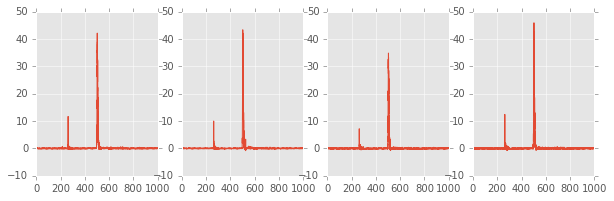

In [31]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 50, option='all')

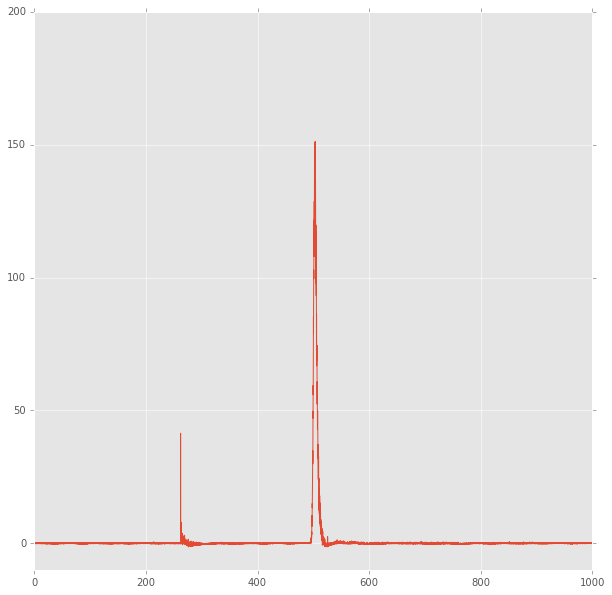

In [32]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 200, option='sum')

In [33]:
PMT.items

Int64Index([0, 1, 2, 3, 4], dtype='int64')

In [35]:
wf_zs = wf_thr(sPMT(PMT),threshold=6)

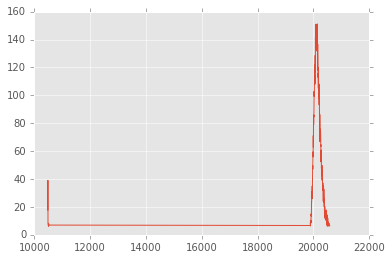

In [36]:
plt.plot(wf_zs.ene_pes)

In [37]:
s12 = find_S12(wf_zs)

In [38]:
len(s12)

2

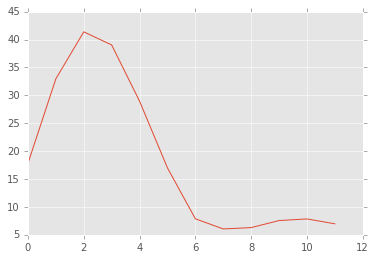

In [39]:
plt.plot(s12[0].ene_pes)

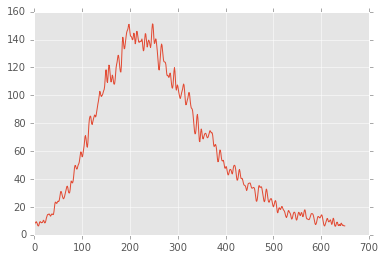

In [40]:
plt.plot(s12[1].ene_pes)

In [41]:
s1 = s12[0]

In [42]:
s2 = s12[1]

In [43]:
s2rb = rebin_waveform(s2, stride = 40)

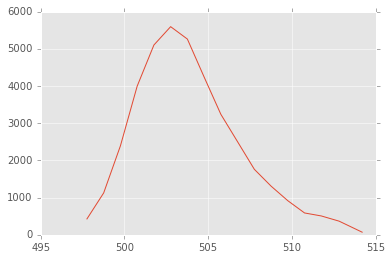

In [44]:
plt.plot(s2rb['time_mus'], s2rb['ene_pes'])

In [45]:
print("ene s2 = {} pes; ene s2rb = {} pes (must be the same)".format(np.sum(s2.ene_pes.values), 
                                                                     np.sum(s2rb.ene_pes.values)))

ene s2 = 39394.8933601 pes; ene s2rb = 39394.8933601 pes (must be the same)


In [46]:
print("t0 = {} mus".format(find_t0(s1).time_mus.values[0]))

t0 = 262.15 mus


In [47]:
s2rb.describe()

,ene_pes,indx,time_mus
count,17.000000,17.000000,17.000000
mean,2317.346668,20070.411765,505.792022
std,1903.553083,100.029407,5.099564
min,70.429598,19911.000000,497.762500
25%,586.968513,19991.000000,501.762500
50%,1760.439804,20071.000000,505.762500
75%,3995.003128,20151.000000,509.762500
max,5595.159821,20221.000000,514.202500


In [48]:
s2rb.describe().ene_pes

count      17.000000
mean     2317.346668
std      1903.553083
min        70.429598
25%       586.968513
50%      1760.439804
75%      3995.003128
max      5595.159821
Name: ene_pes, dtype: float64

In [49]:
s2rb.describe().ene_pes['max']

5595.1598205566406

In [50]:
ts2, emaxs2 = s2_peak(s2)

In [51]:
print("ts2 = {} mus, emax = {} pes".format(ts2,emaxs2))

ts2 = 514.2025 mus, emax = 5595.15982056 pes


In [52]:
print('tint = {} mus '.format(find_t(s1,s2)))

tint = 252.0525 mus 


### SiPMs

In [131]:
SIPM, SIBSL  = waveform_panel(sipmrwf,sipmdf,mau_len = 100, calib_constat =False, adc_to_pes=20, type = 'SIPM', event=0)

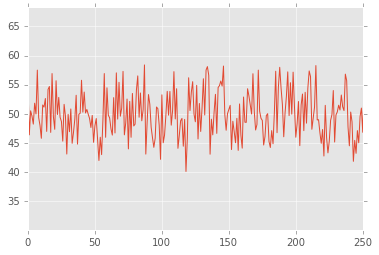

In [132]:
mpl.plts(SIBSL, signal_start=0, signal_end=250, offset=10)

In [133]:
SIBSL.describe()

count    256.000000
mean      49.987266
std        3.973787
min       40.140000
25%       46.982500
50%       49.780000
75%       52.950000
max       58.410000
dtype: float64

In [134]:
SIPM

<class 'pandas.core.panel.Panel'>
Dimensions: 257 (items) x 1000 (major_axis) x 3 (minor_axis)
Items axis: 0 to 256
Major_axis axis: 0 to 999
Minor_axis axis: ene_pes to time_mus

In [183]:
esipmdf = sipm_s2_energy(SIPM, s2, thr_min=25, thr_s2 =2.0)

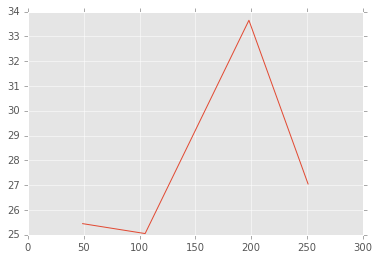

In [144]:
plt.plot(esipmdf.sipm_indx,esipmdf.etot_pes)

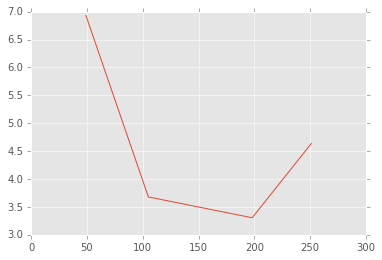

In [145]:
plt.plot(esipmdf.sipm_indx,esipmdf.es2_pes)

In [146]:
esipmdf

,sipm_indx,etot_pes,es2_pes
0,49,25.450031,6.931001
1,105,25.049954,3.678499
2,198,33.650091,3.305502
3,251,27.049993,4.636000


In [156]:
epmt = energy_sum(PMT, thr=0)

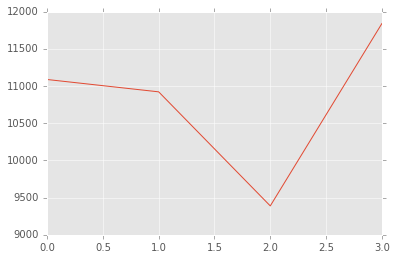

In [157]:
plt.plot(epmt)

In [158]:
esipm = energy_sum(SIPM, thr=0)

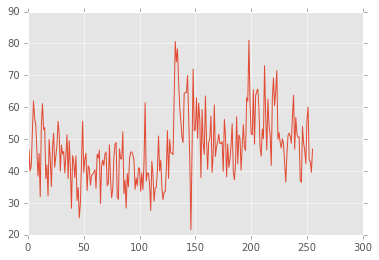

In [159]:
plt.plot(esipm)

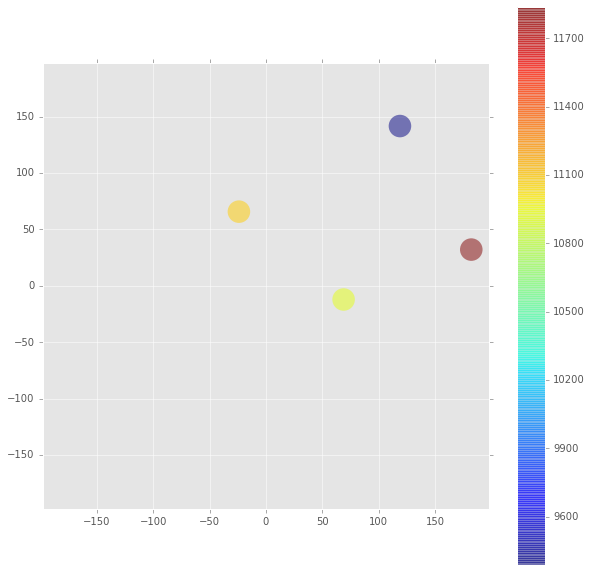

In [160]:
plot_sensors(gdf,pmtdf, epmt, radius=10)

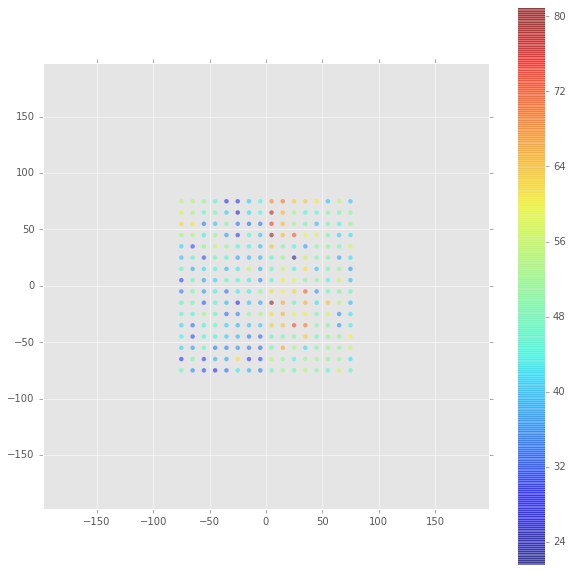

In [161]:
plot_sensors(gdf,sipmdf, esipm, radius=2)

In [162]:
PMT, BSL  = waveform_panel(pmtrwf,pmtdf,calib_constat =True, type = 'PMT', event=1)

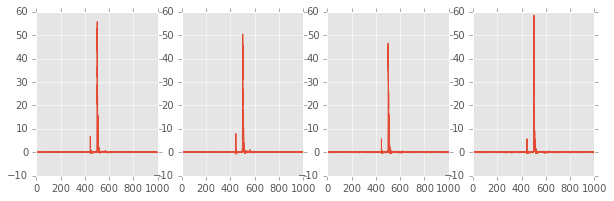

In [165]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 60, option='all')

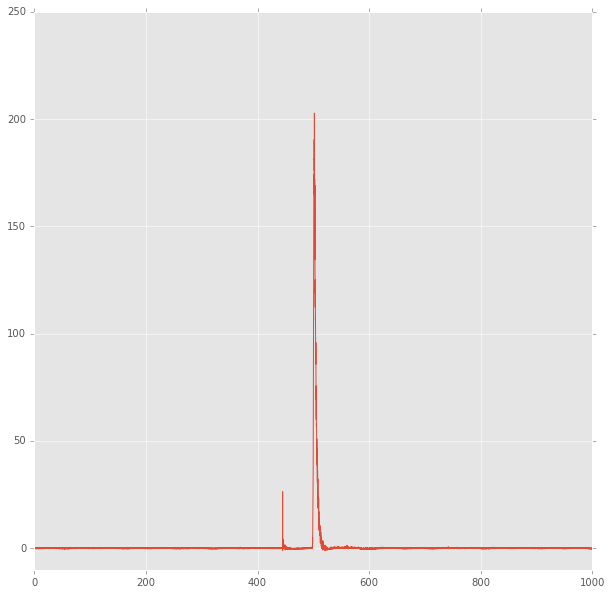

In [166]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 250, option='sum')

In [167]:
wf_zs = wf_thr(sPMT(PMT),threshold=6)

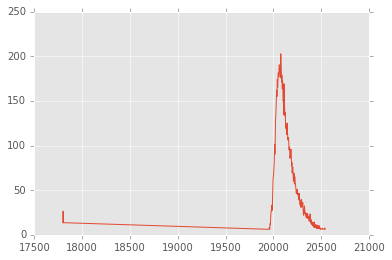

In [168]:
plt.plot(wf_zs.ene_pes)

In [169]:
s12 = find_S12(wf_zs)

In [170]:
len(s12)

2

In [171]:
s1 = s12[0]
s2 = s12[1]

In [172]:
s2rb = rebin_waveform(s2, stride = 40)

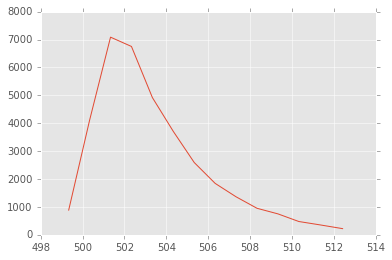

In [173]:
plt.plot(s2rb['time_mus'], s2rb['ene_pes'])

In [174]:
print("ene s2 = {} pes; ene s2rb = {} pes (must be the same)".format(np.sum(s2.ene_pes.values), 
                                                                     np.sum(s2rb.ene_pes.values)))

ene s2 = 35999.8014841 pes; ene s2rb = 35999.8014841 pes (must be the same)


In [175]:
print("t0 = {} mus".format(find_t0(s1).time_mus.values[0]))

t0 = 445.025 mus


In [176]:
ts2, emaxs2 = s2_peak(s2)

In [177]:
print("ts2 = {} mus, emax = {} pes".format(ts2,emaxs2))

ts2 = 512.428448276 mus, emax = 7083.81370544 pes


In [178]:
print('tint = {} mus '.format(find_t(s1,s2)))

tint = 67.4034482759 mus 


In [180]:
SIPM, SIBSL  = waveform_panel(sipmrwf,sipmdf,mau_len = 100, calib_constat =False, adc_to_pes=20, type = 'SIPM', event=1)

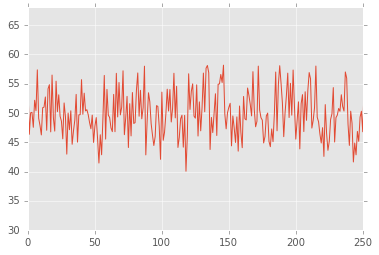

In [181]:
mpl.plts(SIBSL, signal_start=0, signal_end=250, offset=10)

In [186]:
esipmdf = sipm_s2_energy(SIPM, s2, thr_min=0, thr_s2 =0)

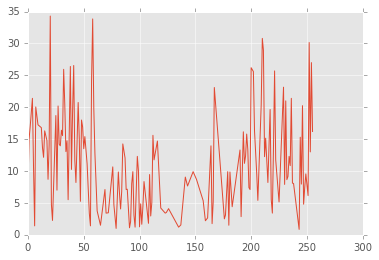

In [187]:
plt.plot(esipmdf.sipm_indx,esipmdf.etot_pes)

### RUN 2366

In [28]:
!ls -lh ../../../waveforms/hdf5/*2366*.h5

-rw-rw-r-- 1 icuser icuser 130M Oct  9 18:28 ../../../waveforms/hdf5/run_2366.gdc1next.000.next1el_2366.root.h5
-rw-rw-r-- 1 icuser icuser 130M Oct  9 18:29 ../../../waveforms/hdf5/run_2366.gdc1next.001.next1el_2366.root.h5
-rw-rw-r-- 1 icuser icuser 130M Oct  9 18:30 ../../../waveforms/hdf5/run_2366.gdc1next.002.next1el_2366.root.h5
-rw-rw-r-- 1 icuser icuser 131M Oct  9 18:30 ../../../waveforms/hdf5/run_2366.gdc1next.003.next1el_2366.root.h5
-rw-rw-r-- 1 icuser icuser 130M Oct  9 18:31 ../../../waveforms/hdf5/run_2366.gdc1next.004.next1el_2366.root.h5
-rw-rw-r-- 1 icuser icuser 130M Oct  9 18:32 ../../../waveforms/hdf5/run_2366.gdc1next.005.next1el_2366.root.h5
-rw-rw-r-- 1 icuser icuser 131M Oct  9 18:33 ../../../waveforms/hdf5/run_2366.gdc1next.006.next1el_2366.root.h5
-rw-rw-r-- 1 icuser icuser 131M Oct  9 18:34 ../../../waveforms/hdf5/run_2366.gdc1next.007.next1el_2366.root.h5
-rw-rw-r-- 1 icuser icuser 130M Oct  9 18:35 ../../../waveforms/hdf5/run_2366.gdc1next.008.next1el_2366.

In [30]:
h5f =tb.open_file('../../../waveforms/hdf5/run_2366.gdc1next.000.next1el_2366.root.h5')

In [31]:
h5f

File(filename=../../../waveforms/hdf5/run_2366.gdc1next.000.next1el_2366.root.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/RD (Group) ''
/RD/pmtrwf (EArray(382, 12, 48000), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/Sensors (Group) ''
/Sensors/DataPMT (Table(12,)) ''
  description := {
  "channel": Int32Col(shape=(), dflt=0, pos=0),
  "active": Int32Col(shape=(), dflt=0, pos=1),
  "position": Float32Col(shape=(3,), dflt=0.0, pos=2),
  "gain": Float64Col(s

In [35]:
pmtrwf,pmtdf,gdf =get_pmt_vectors(h5f)

In [36]:
PMT, BSL  = waveform_panel(pmtrwf,pmtdf,calib_constat =True, type = 'PMT', event=0)

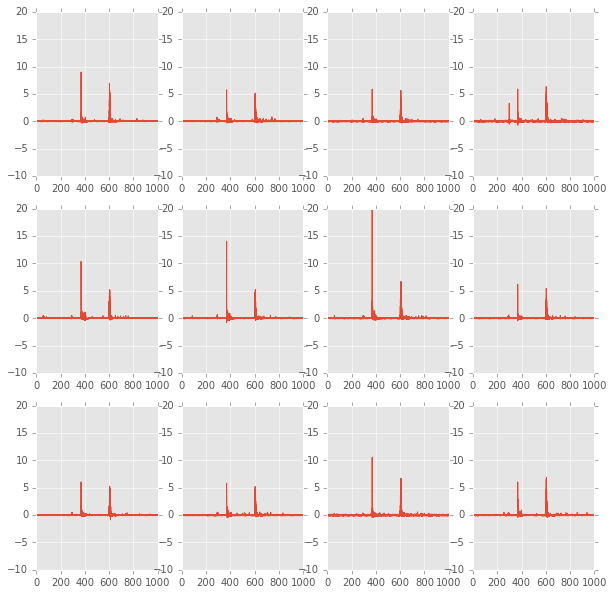

In [39]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 20, option='all')

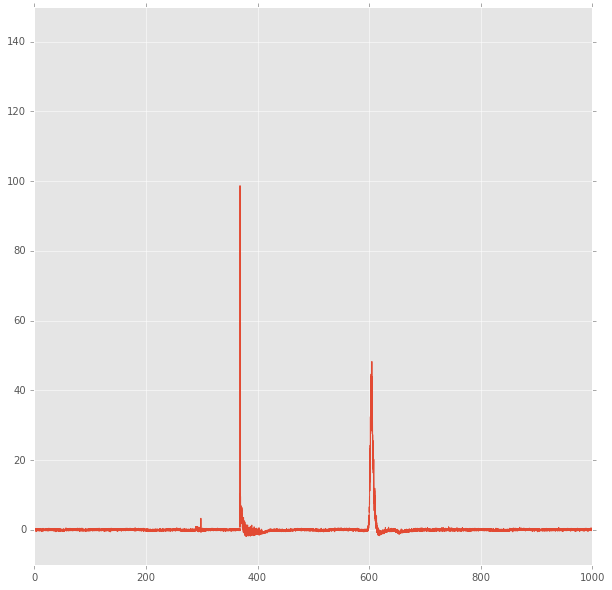

In [57]:
plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 150, option='sum')

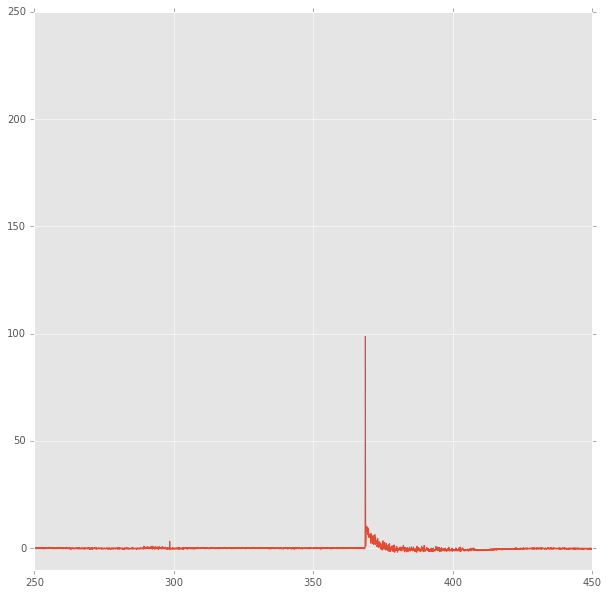

In [42]:
plot_PPMT(PMT, tmin=250, tmax=450, emin = -10, emax = 250, option='sum')

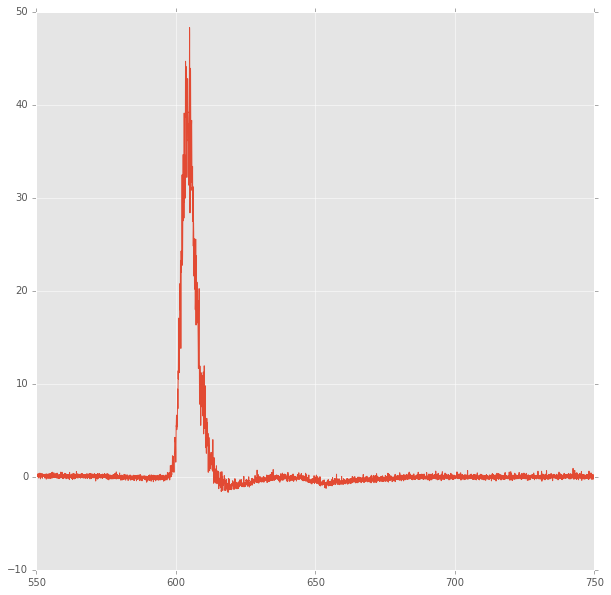

In [45]:
plot_PPMT(PMT, tmin=550, tmax=750, emin = -10, emax = 50, option='sum')

In [104]:
s12 = find_S12(wf_thr(sPMT(PMT),threshold=6))

In [105]:
len(s12)

3

In [54]:
len(s12[0])

64

In [55]:
len(s12[1])

4

In [56]:
len(s12[2])

401

In [58]:
s1 = s12[0]

In [59]:
s2 = s12[2]

In [61]:
np.sum(s2.ene_pes.values)

9285.112699508667

In [62]:
find_t0(s1)

,time_mus,ene_pes,indx
3,368.625,98.711174,14745.0


In [65]:
ts2, emaxs2 = s2_peak(s2)

In [66]:
ts2

611.125

In [68]:
emaxs2

48.295433044433594

In [69]:
find_t(s1,s2)

242.5

In [70]:
epmt = energy_sum(PMT, thr=0)

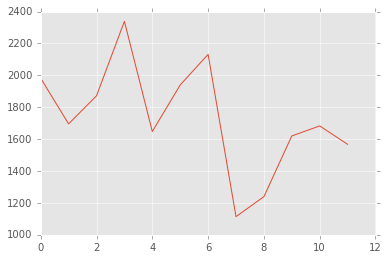

In [71]:
plt.plot(epmt)

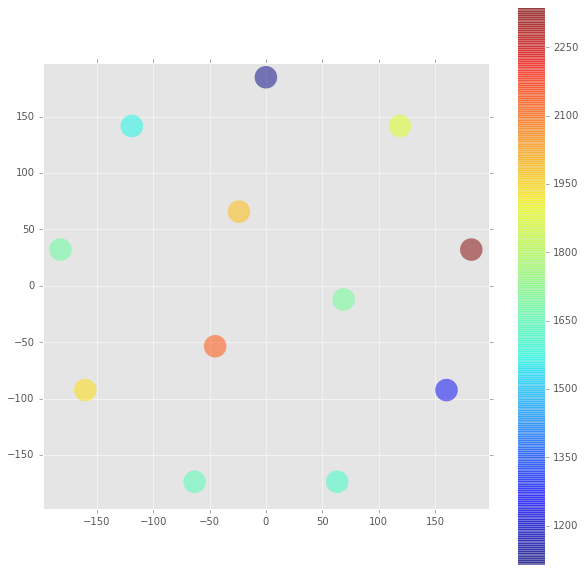

In [72]:
plot_sensors(gdf,pmtdf, epmt, radius=10)

In [73]:
x = pmtdf['x'].values

In [74]:
x

array([ -23.94140053,   68.93650055,  118.91600037,  182.18899536,
        -63.27370071, -160.21499634,  -44.99509811,   -0.        ,
        160.21499634,   63.27370071, -182.18899536, -118.91600037], dtype=float32)

In [76]:
np.dot(x,epmt)/np.sum(epmt)

0.72899437717134452

In [78]:
y = pmtdf['y'].values

In [79]:
np.dot(y,epmt)/np.sum(epmt)

-2.1123627557180513

In [80]:
epmt

0     1982.077915
1     1695.592096
2     1871.691266
3     2338.890845
4     1647.982336
5     1939.618454
6     2131.733983
7     1113.907473
8     1239.179890
9     1619.974036
10    1682.946544
11    1567.643963
dtype: float64

In [100]:
s2.describe()

,time_mus,ene_pes,indx
count,401.000000,401.000000,401.000000
mean,605.388030,23.154895,24215.521197
std,2.927488,11.477493,117.099531
min,600.200000,6.008355,24008.000000
25%,602.875000,11.843847,24115.000000
50%,605.375000,22.265060,24215.000000
75%,607.875000,32.387573,24315.000000
max,611.125000,48.295433,24445.000000


In [101]:
s1.describe()

,time_mus,ene_pes,indx
count,64.000000,64.000000,64.000000
mean,369.553516,13.852556,14782.140625
std,0.631150,19.985552,25.246007
min,368.550000,6.040528,14742.000000
25%,369.068750,6.490131,14762.750000
50%,369.462500,7.577367,14778.500000
75%,370.181250,9.549287,14807.250000
max,370.800000,98.711174,14832.000000


In [124]:
s1.describe().time_mus.max()

370.80000000000001

In [125]:
def pmt_alpha(pmtrwf,pmtdf, geomdf, thr=7*pes, t_trigger = 600, log='INFO', plot=False, event_list=[0]):
    """
    alpha analysis based on PMTs
    """
    lg = 'logging.'+DEBUG
    logger.setLevel(eval(lg))

    evl = len(event_list)
    t0 = np.zeros(evl, dtype=np.float32)
    t = np.zeros(evl, dtype=np.float32)
    xb = np.zeros(evl, dtype=np.float32)
    yb = np.zeros(evl, dtype=np.float32)
    s2e = np.zeros(evl, dtype=np.float32)
    s2l = np.zeros(evl, dtype=np.float32)
    ns1 = np.zeros(evl, dtype=np.int32)
    ns2 = np.zeros(evl, dtype=np.int32)

    for event in event_list:
        logger.info('event = {}'.format(event))

        PMT, BSL  = waveform_panel(pmtrwf,pmtdf,event=event)
        if plot:
            plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 20, option='all')
            plt.show()
            wait()
            plot_PPMT(PMT, tmin=0, tmax=1000, emin = -10, emax = 150, option='sum')
            plt.show()
            wait()

        s12 = find_S12(wf_thr(sPMT(PMT),threshold=thr))

        logger.debug('length of s12 = {}'.format(len(s12)))
        S1 = []
        S2 = []
        for s in s12:
            logger.debug('evaluating s in s12: s ={}'.format(s.describe()))
            logger.debug('tmax ={}'.format(s.describe().time_mus.max()))
            if s.describe().time_mus.max() < t_trigger: #s1
                S1.append(s)
            else:
                S2.append(s)

        logger.debug('length of S1 list = {}'.format(len(S1)))
        logger.debug('length of S2 list = {}'.format(len(S2)))

        if (len(S1) == 0):
            logger.warning("S1 not found, ignore event")
            t0[event] = -999
            t[event] = -999
            xb[event] = -999
            yb[event] = -999
            s2e[event] = -999
            s2l[event] = -999
            ns1[event] = 0
            ns2[event] = len(S2)
            continue
        if (len(S2) == 0):
            logger.warning("S2 not found, ignore event")
            t0[event] = -999
            t[event] = -999
            xb[event] = -999
            yb[event] = -999
            s2e[event] = -999
            s2l[event] = -999
            ns1[event] = len(S1)
            ns2[event] = 0
            continue

        ns1[event] = len(S1)
        ns2[event] = len(S2)

        s1 = S1[0]

        if len(S1) > 1:
            cmax = 0
            i=0
            imax = 0
            for s in S1:
                if s.describe().time_mus.count() > cmax:
                    cmax = s.describe().time_mus.count()
                    imax = i
            i+=1
            s1 = S1[imax]

        logger.debug('found s1 = {}'.format(s1.describe()))



        s2 = S2[0]
        es2 = s12_energy(s2)

        if len(S2) > 1:
            emax = 0
            i=0
            imax = 0
            for s in S2:
                es2 = s12_energy(s)
                if es2 > emax:
                    emax =  es2
                    imax = i
            i+=1
            s2 = S2[imax]

        epmt = energy_sum(PMT, thr=0)

        logger.debug('found s2 = {}'.format(s2.describe()))

        t0[event] = find_t0(s1)
        t[event] = find_t(s1,s2)
        xb[event], yb[event] = pmt_barycenter(pmtdf, epmt)
        s2l[event] = s12_length(s2)



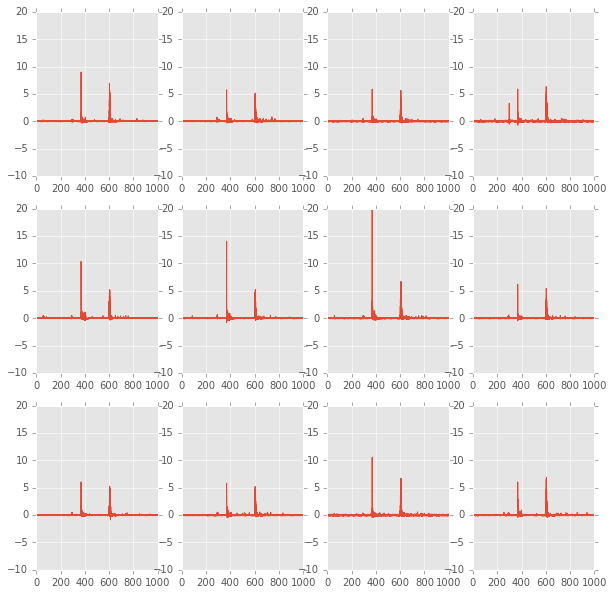

Press a key...


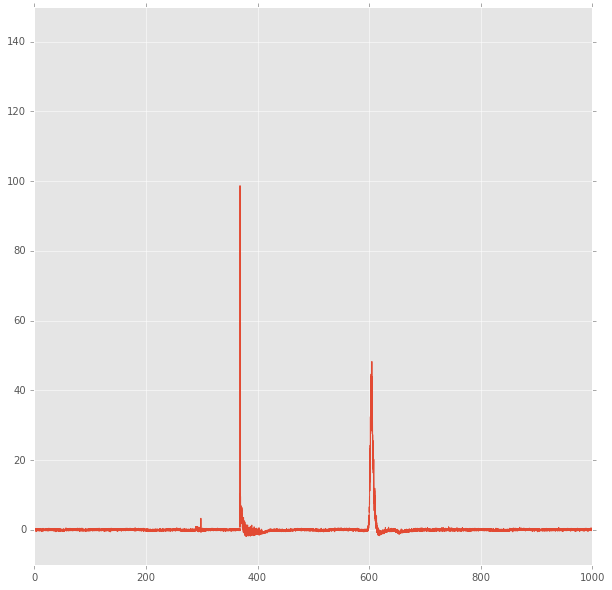

Press a key...
length of s12 = 2
evaluating s in s12: s =         time_mus    ene_pes          indx
count   35.000000  35.000000     35.000000
mean   369.122857  19.947708  14764.914286
std      0.332347  25.605684     13.293898
min    368.550000   7.106111  14742.000000
25%    368.937500   8.540880  14757.500000
50%    369.150000   9.372319  14766.000000
75%    369.362500  10.226789  14774.500000
max    369.650000  98.711174  14786.000000
tmax =<bound method Series.max of count     35.000000
mean     369.122857
std        0.332347
min      368.550000
25%      368.937500
50%      369.150000
75%      369.362500
max      369.650000
Name: time_mus, dtype: float64>
evaluating s in s12: s =         time_mus     ene_pes          indx
count  380.000000  380.000000    380.000000
mean   605.331447   24.080438  24213.257895
std      2.777059   11.073767    111.082378
min    600.575000    7.267888  24023.000000
25%    602.943750   14.383781  24117.750000
50%    605.312500   23.216208  24212.50000

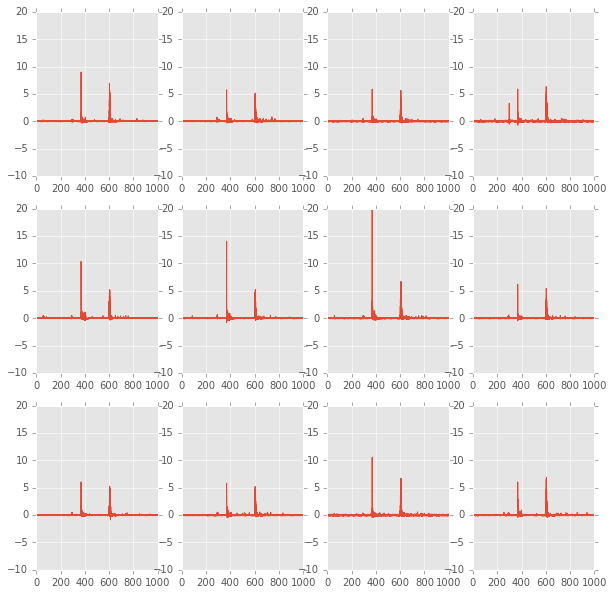

Press a key...


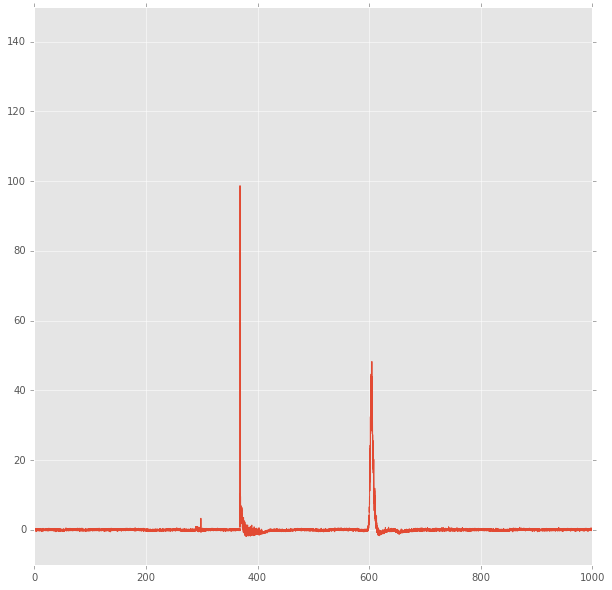

Press a key...
length of s12 = 2
evaluating s in s12: s =         time_mus    ene_pes          indx
count   35.000000  35.000000     35.000000
mean   369.122857  19.947708  14764.914286
std      0.332347  25.605684     13.293898
min    368.550000   7.106111  14742.000000
25%    368.937500   8.540880  14757.500000
50%    369.150000   9.372319  14766.000000
75%    369.362500  10.226789  14774.500000
max    369.650000  98.711174  14786.000000
tmax =<bound method Series.max of count     35.000000
mean     369.122857
std        0.332347
min      368.550000
25%      368.937500
50%      369.150000
75%      369.362500
max      369.650000
Name: time_mus, dtype: float64>
evaluating s in s12: s =         time_mus     ene_pes          indx
count  380.000000  380.000000    380.000000
mean   605.331447   24.080438  24213.257895
std      2.777059   11.073767    111.082378
min    600.575000    7.267888  24023.000000
25%    602.943750   14.383781  24117.750000
50%    605.312500   23.216208  24212.50000

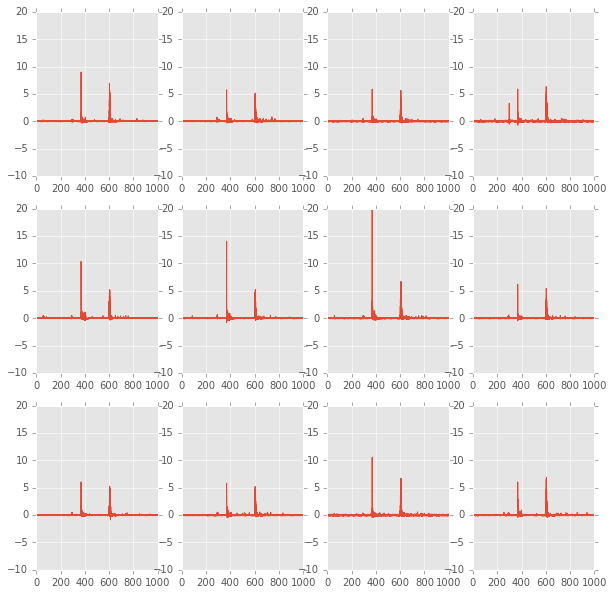

Press a key...


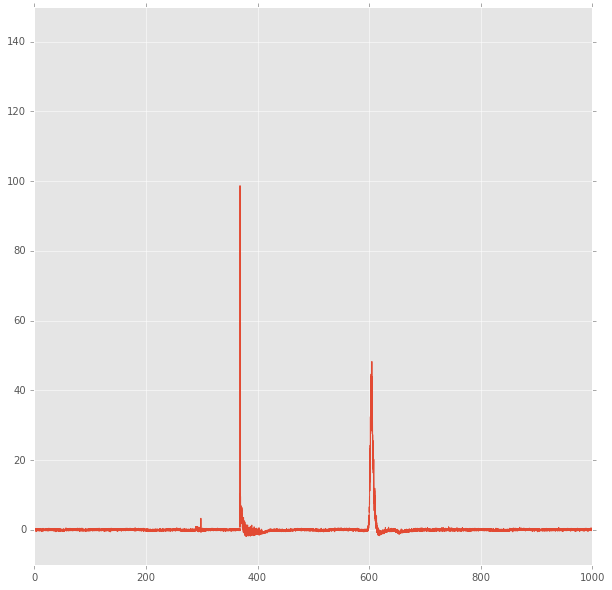

Press a key...
length of s12 = 2
evaluating s in s12: s =         time_mus    ene_pes          indx
count   35.000000  35.000000     35.000000
mean   369.122857  19.947708  14764.914286
std      0.332347  25.605684     13.293898
min    368.550000   7.106111  14742.000000
25%    368.937500   8.540880  14757.500000
50%    369.150000   9.372319  14766.000000
75%    369.362500  10.226789  14774.500000
max    369.650000  98.711174  14786.000000
tmax =<bound method Series.max of count     35.000000
mean     369.122857
std        0.332347
min      368.550000
25%      368.937500
50%      369.150000
75%      369.362500
max      369.650000
Name: time_mus, dtype: float64>
evaluating s in s12: s =         time_mus     ene_pes          indx
count  380.000000  380.000000    380.000000
mean   605.331447   24.080438  24213.257895
std      2.777059   11.073767    111.082378
min    600.575000    7.267888  24023.000000
25%    602.943750   14.383781  24117.750000
50%    605.312500   23.216208  24212.50000

In [126]:
pmt_alpha(pmtrwf,pmtdf,thr=7, t_trigger = 600, event_list=[0,1,2])

In [85]:
xb,yb = pmt_barycenter(gdf,pmtdf, epmt)

In [86]:
print(xb,yb)

0.728994377171 -2.11236275572


In [87]:
s2_length(s2)

10.924999999999955

In [88]:
s2_energy(s2)

9285.112699508667

In [89]:
6./5.

1.2